In [1]:
import pandas as pd
from matplotlib import rc
import seaborn as sns
import numpy as np
import missingno as msno
import plotly.graph_objects as go
from fbprophet import Prophet
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [ ]:
!pip install fbprophet

In [3]:
!wget -O registro.csv https://raw.githubusercontent.com/Brocoleo/Calidad-del-Aire/master/datos.csv

--2021-12-18 19:38:57--  https://raw.githubusercontent.com/Brocoleo/Calidad-del-Aire/master/datos.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1522273 (1.5M) [text/plain]
Saving to: ‘registro.csv’

registro.csv        100%[===================>]   1.45M  --.-KB/s    in 0.05s   

2021-12-18 19:38:57 (31.5 MB/s) - ‘registro.csv’ saved [1522273/1522273]



DATASET DE CONCENTRACION DE MP2.5 QUE SE ASOCIA LA 
CONTAMINACION URBANA, EN GRAN MEDIDA DE LAS EMISIONES DE LOS VEHICULOS DIESEL EN LA CIUDAD DE CURICO. ESTE CONTAMINANTE AFECTA LA SALUD DE LAS PERSONAS EN SUS VIAS RESPIRATORIAS, EXISTEN RESULTADOS DONDE EL AUMENTO DE ESTA CONCENTRACION SE RELACIONA A UNA MAYOR HOSPITALIZACION.

In [4]:
data = pd.read_csv('registro.csv', delimiter=';', decimal=",")
data.head(10)

FECHA (YYMMDD)  HORA (HHMM)  ...  Registros no validados  Unnamed: 5
0          120707          100  ...                     NaN         NaN
1          120707          200  ...                     NaN         NaN
2          120707          300  ...                     NaN         NaN
3          120707          400  ...                     NaN         NaN
4          120707          500  ...                     NaN         NaN
5          120707          600  ...                     NaN         NaN
6          120707          700  ...                     NaN         NaN
7          120707          800  ...                     NaN         NaN
8          120707          900  ...                     NaN         NaN
9          120707         1000  ...                     NaN         NaN

[10 rows x 6 columns]

# LIMPIEZA DE DATOS

CANTIDAD DE DATOS FALTANTES EN EL DATASET, PARA REALIZAR LA LIMPIEZA SE ELIMINARAN LAS COLUMNAS DE REGISTROS PRELIMINARES, REGISTROS NO VALIDOS Y UNNAMED, QUE NO PRESENTAN RELEVANCIA PARA EL ANALISIS.





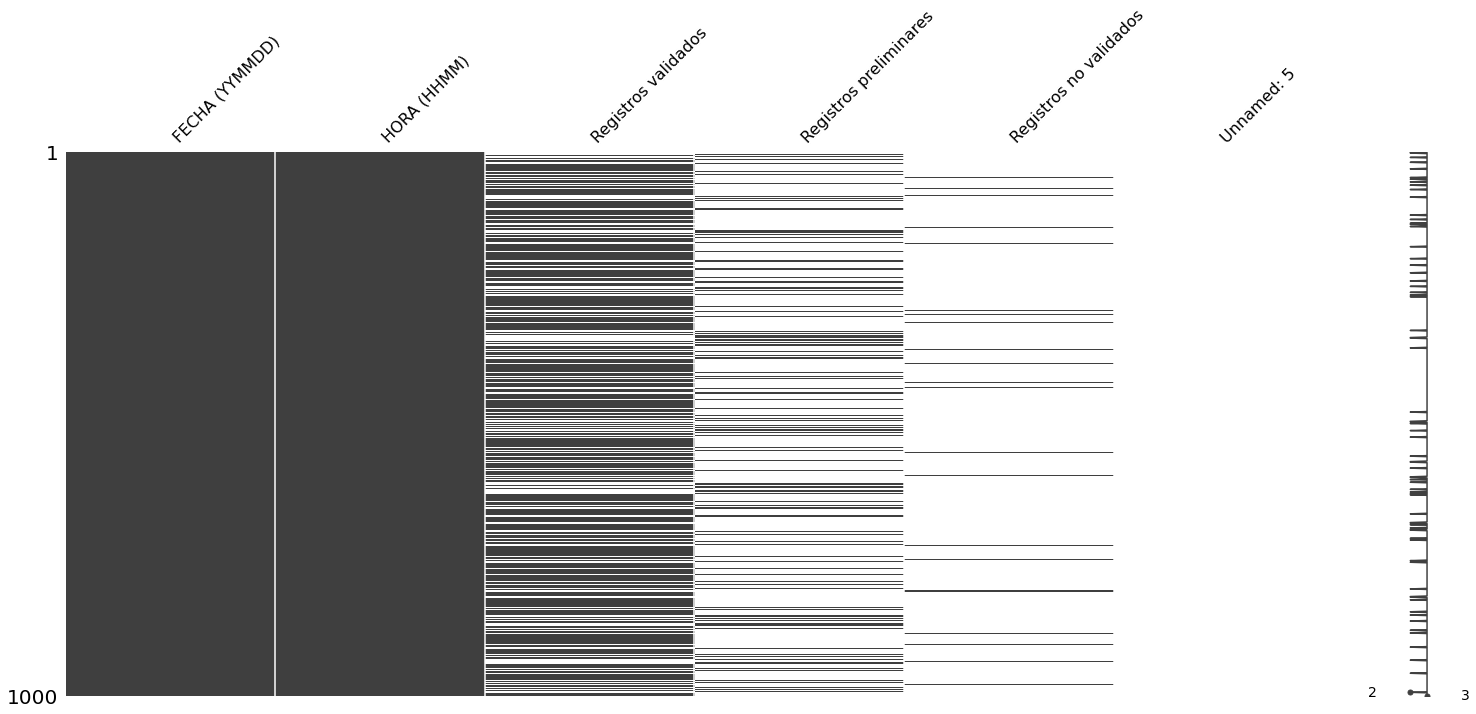

In [5]:
import missingno as msno
%matplotlib inline
msno.matrix(data.sample(1000))

In [6]:
data1=data.drop(['Unnamed: 5', 'Registros no validados', 'Registros preliminares'], axis=1)
data1.head()

FECHA (YYMMDD)  HORA (HHMM)  Registros validados
0          120707          100                  NaN
1          120707          200                  NaN
2          120707          300                  NaN
3          120707          400                  NaN
4          120707          500                  NaN

TAMBIEN ANALIZAREMOS SOLO LOS REGISTROS VALIDOS QUE TENGAN UN REGISTRO NO NULO EN EL DATASET, ESTA COLUMNA ES DONDE SE ENCUENTRA LA MAYORIA DE LOS DATOS ACERCA DE LA CONCENTRACION DE MP2.5

In [7]:
data1.dropna(subset=['Registros validados'], inplace=True)
data1

FECHA (YYMMDD)  HORA (HHMM)  Registros validados
5687           130301            0                  6.0
5688           130301          100                  3.0
5689           130301          200                  4.0
5690           130301          300                  4.0
5691           130301          400                  2.0
...               ...          ...                  ...
65610          191231         1900                 21.0
65611          191231         2000                 28.0
65612          191231         2100                 30.0
65613          191231         2200                 33.0
65614          191231         2300                 21.0

[57743 rows x 3 columns]

RENOMBRAMOS ALGUNAS COLUMNAS CON UN NOMBRE EXTENSO Y LE DAMOS FORMATO A LA FECHA

In [8]:
data1 = data1.rename(columns={'FECHA (YYMMDD)': 'FECHA', 'HORA (HHMM)': 'HORA', 'Registros validados':'Registros'})
data1['FECHA'] = data1['FECHA'] + 20000000
data1

FECHA  HORA  Registros
5687   20130301     0        6.0
5688   20130301   100        3.0
5689   20130301   200        4.0
5690   20130301   300        4.0
5691   20130301   400        2.0
...         ...   ...        ...
65610  20191231  1900       21.0
65611  20191231  2000       28.0
65612  20191231  2100       30.0
65613  20191231  2200       33.0
65614  20191231  2300       21.0

[57743 rows x 3 columns]

In [9]:
data1['FECHA'] = pd.to_datetime(data1['FECHA'], format='%Y%m%d')
data1

FECHA  HORA  Registros
5687  2013-03-01     0        6.0
5688  2013-03-01   100        3.0
5689  2013-03-01   200        4.0
5690  2013-03-01   300        4.0
5691  2013-03-01   400        2.0
...          ...   ...        ...
65610 2019-12-31  1900       21.0
65611 2019-12-31  2000       28.0
65612 2019-12-31  2100       30.0
65613 2019-12-31  2200       33.0
65614 2019-12-31  2300       21.0

[57743 rows x 3 columns]

AHORA LE DAMOS FORMATO A LA HORA

In [10]:
data1['HORA'] = data1['HORA'].replace(0, '0000')
data1['HORA'] = data1['HORA'].apply(str)
data1['HORA']=data1['HORA'].apply(lambda x: pd.to_timedelta(x[:-2] + ':' + x[-2:] + ':00'))
data1['HORA'] = data1['HORA'].astype(str).map(lambda x: x[7:])
data1

FECHA      HORA  Registros
5687  2013-03-01  00:00:00        6.0
5688  2013-03-01  01:00:00        3.0
5689  2013-03-01  02:00:00        4.0
5690  2013-03-01  03:00:00        4.0
5691  2013-03-01  04:00:00        2.0
...          ...       ...        ...
65610 2019-12-31  19:00:00       21.0
65611 2019-12-31  20:00:00       28.0
65612 2019-12-31  21:00:00       30.0
65613 2019-12-31  22:00:00       33.0
65614 2019-12-31  23:00:00       21.0

[57743 rows x 3 columns]

FINALMENTE COMBINAMOS LA HORA Y FECHA PARA SOLO TENER UNA COLUMNA DE LA SERIE DE TIEMPO

In [11]:
data1['Date'] = pd.to_datetime(data1['FECHA'].astype(str) + ' ' + data1['HORA'].astype(str))
data1.head(100)

FECHA      HORA  Registros                Date
5687 2013-03-01  00:00:00        6.0 2013-03-01 00:00:00
5688 2013-03-01  01:00:00        3.0 2013-03-01 01:00:00
5689 2013-03-01  02:00:00        4.0 2013-03-01 02:00:00
5690 2013-03-01  03:00:00        4.0 2013-03-01 03:00:00
5691 2013-03-01  04:00:00        2.0 2013-03-01 04:00:00
...         ...       ...        ...                 ...
5782 2013-03-04  23:00:00       14.0 2013-03-04 23:00:00
5783 2013-03-05  00:00:00       17.0 2013-03-05 00:00:00
5784 2013-03-05  01:00:00       38.0 2013-03-05 01:00:00
5785 2013-03-05  02:00:00       20.0 2013-03-05 02:00:00
5786 2013-03-05  03:00:00       22.0 2013-03-05 03:00:00

[100 rows x 4 columns]

In [12]:
data1=data1.drop(['FECHA', 'HORA'], axis=1)
data1.head()

Registros                Date
5687        6.0 2013-03-01 00:00:00
5688        3.0 2013-03-01 01:00:00
5689        4.0 2013-03-01 02:00:00
5690        4.0 2013-03-01 03:00:00
5691        2.0 2013-03-01 04:00:00

AHORA GRAFICAMOS EL MP 2.5 EN EL AIRE SOBRE EL TIEMPO EN LA CIUDAD DE CURICO, EXISTE UNA REPETICION EN LOS VALORES MAS ALTOS DE CONCENTRACION DURANTE EL AÑO Y ESTAS SUELEN COINCIDIR CON LOS  MESES DE INVIERNO DESDE JULIO A SEPTIEMBRE. 

In [25]:
fig = px.line(data1, x="Date", y="Registros", title='MP 2.5 en el aire de Curico')
fig.update_layout(xaxis_title='Fecha',
                   yaxis_title='MP 2.5')
fig.show()

In [14]:
split_date = '2018-01-05 03:00:00'
pjme_train = data1.loc[data1.Date <= split_date].copy()
pjme_test = data1.loc[data1.Date > split_date].copy()

AHORA LO QUE HACEMOS ES  REALIZAR LA DIVISION DEL DATASET CON EL OBJETIVO DE ENTRENAR EL MODELO CON UNA MAYORITARIA CANTIDAD DE LOS DATOS TOTALES Y DEJAR UN PORCENTAJE PARA REALIZAR LA POSTERIOR LA PRECISION O EL ACCURACY DEL MODELO APLICADO AL DATASET. 

In [15]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=pjme_train.Date, y=pjme_train.Registros,
                    mode='lines',
                    name='Entrenamiento'))
fig.add_trace(go.Scatter(x=pjme_test.Date, y=pjme_test.Registros,
                    mode='lines',
                    name='Validacion'))
fig.update_layout(title='Separacion de datos para entrenar con Prophet',
                   xaxis_title='Fecha',
                   yaxis_title='MP 2.5')

fig.show()

DAMOS EL FORMATO A LOS DATOS PARA UTILIZAR EL MODELO PROPHET DESARROLLADO POR FACEBOOK, QUE UTILIZA SERIES DE TIEMPO CON 2 COLUMNAS: ´INDEX´ E ´Y´ 

In [16]:
pjme_train.reset_index() \
    .rename(columns={'Date':'ds',
                     'Registros':'y'}).head()

index    y                  ds
0   5687  6.0 2013-03-01 00:00:00
1   5688  3.0 2013-03-01 01:00:00
2   5689  4.0 2013-03-01 02:00:00
3   5690  4.0 2013-03-01 03:00:00
4   5691  2.0 2013-03-01 04:00:00

ENTRENAMOS EL SET PARA EL MODELO DE PREDICCION DE PROHPET

In [17]:
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Date':'ds',
                               'Registros':'y'}))

TENEMOS LOS RESULTADOS DE MODELO CREADO POR FACEBOOK, EL EL CUAL EXISTEN DIFERENTES COLUMNAS RELACIONADAS AL ANALISIS DE PREDECIR LOS VALORES SIGUIENTES SOBRE EL TIEMPO

In [18]:
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Date':'ds'}))
pjme_test_fcst.head()

ds      trend  ...  multiplicative_terms_upper      yhat
0 2018-01-05 04:00:00  22.394020  ...                         0.0  0.726694
1 2018-01-05 05:00:00  22.393551  ...                         0.0 -1.764837
2 2018-01-05 06:00:00  22.393083  ...                         0.0 -1.899719
3 2018-01-05 07:00:00  22.392614  ...                         0.0 -0.290623
4 2018-01-05 08:00:00  22.392145  ...                         0.0  1.495853

[5 rows x 22 columns]

GRAFICA DE LAS PREDICCIONES DE PROPHET

In [19]:
fig = px.line(pjme_test_fcst, x="ds", y="yhat")
fig.update_layout(title='Predicciones de MP 2.5 en el aire con Prophet',
                   xaxis_title='Fecha',
                   yaxis_title='MP 2.5')
fig.show()

ANALISIS DE LOS ERRORES DEL MODELO DE PROPHET

MEAN SQUARED ERROR

In [22]:
mean_squared_error(y_true=pjme_test['Registros'],y_pred=pjme_test_fcst['yhat'])

940.6377415727076

MEAN ABSOLUTE ERROR

In [23]:
mean_absolute_error(y_true=pjme_test['Registros'],   y_pred=pjme_test_fcst['yhat'])

17.892339866823637

MEAN PERCENTAGE ERROR

In [24]:
mean_absolute_percentage_error(y_true=pjme_test['Registros'],   y_pred=pjme_test_fcst['yhat'])

1.5696025739084145